# Forecast a multivariate time series

with TensorFlow 2.0

dataset: Brugge field .mat

## Setup

In [1]:
import numpy as np
from os.path import dirname, join as pjoin
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

DATA_PATH = './data'
DATA_FILE_NAME = 'Brugge_en_d.mat'

TRAIN_SPLIT = 150
BUFFER_SIZE = 10000
BATCH_SIZE = 64
EVALUATION_INTERVAL = 200
EPOCHS = 50

data_dir = pjoin(DATA_PATH, DATA_FILE_NAME)
mat_contents = sio.loadmat(data_dir)

data = mat_contents['en_d'][0, 0]

tf.debugging.set_log_device_placement(True)

## Data Preparation

In [2]:
well_dic = {}

for well_index in range(20): # well, Producer P1-P20
    # 'model_num' => dataframe
    model_dic = {}
    well_key = 'P' + str(well_index+1)
    for model_index in range(104): # model, model 1-104
        well_data = np.array([
            data['WOPR'][0,0][well_key][:,model_index],
            data['WBHP'][0,0][well_key][:,model_index],
            data['WWCT'][0,0][well_key][:,model_index],
            data['WWPR'][0,0][well_key][:,model_index]
          ])
        # col1: WOPR, col2: WBHP, col3: WWCT, col4: WWPR
        # row1: day1, ... row 498: day3648
        well_data = well_data.T
        df = pd.DataFrame(data=well_data,
                          index=data['TIME'].flatten(),
                          columns=['WOPR', 'WBHP', 'WWCT', 'WWPR'])
        df.index.name = 'date'
        model_dic[str(model_index+1)] = df
        
    well_dic[str(well_index+1)] = model_dic

In [3]:
def plot_single_well(well_dic, well_num):
    ax = plt.gca()
    true_model_num = 103
    for i in range(104):
        df = well_dic[str(well_num)][str(i+1)]
        if i == true_model_num:
            df.plot(y='WOPR', ax=ax, color='red', legend=False)
        else:
            df.plot(y='WOPR', ax=ax, color='gray', legend=False)
            
    plt.show()

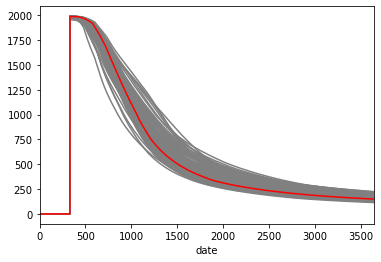

In [4]:
plot_single_well(well_dic, 20)

# Data Preprocessing

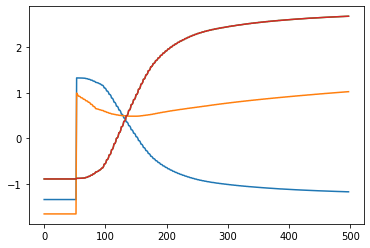

In [5]:
dataset = well_dic['20']['103'].values
# data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
# data_std = dataset[:TRAIN_SPLIT].std(axis=0)

# dataset = (dataset-data_mean)/data_std
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(dataset[:TRAIN_SPLIT])
dataset = scaler.transform(dataset)

plt.plot(dataset)
plt.show()

In [6]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [7]:
past_history = 5
future_target = 1
STEP = 1

print(dataset.shape)

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 0], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)

x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 0],
                                               TRAIN_SPLIT-past_history, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

print(x_train_single.shape, y_train_single.shape, x_val_single.shape, y_val_single.shape)

(498, 4)
(195, 5, 4) (195,) (297, 5, 4) (297,)


In [8]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# train_data_single = train_data_single.prefetch(buffer_size=1)

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()
# val_data_single = val_data_single.prefetch(buffer_size=1)

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMemoryCache in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CacheDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousRandomSeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0


# Define model and Train

In [9]:
single_step_model = tf.keras.models.Sequential()
# single_step_model.add(tf.keras.layers.LSTM(25, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.GaussianNoise(0.01, input_shape=x_train_single.shape[-2:]))
# single_step_model.add(tf.keras.layers.LSTM(50, return_sequences=True,
#                                            input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.LSTM(50, return_sequences=True))
single_step_model.add(tf.keras.layers.Dropout(0.2))

single_step_model.add(tf.keras.layers.LSTM(units=60, activation='relu', return_sequences = True))
single_step_model.add(tf.keras.layers.Dropout(0.2))

# single_step_model.add(tf.keras.layers.LSTM(units=80, activation='relu', return_sequences = True))
# single_step_model.add(tf.keras.layers.Dropout(0.2))

# single_step_model.add(tf.keras.layers.LSTM(units=120, activation='relu', return_sequences = True))
# single_step_model.add(tf.keras.layers.Dropout(0.2))

single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer='adam', loss='mean_squared_error')

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5,verbose=1)

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Qr in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DiagPart in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sign in device /job:localhost/replica:0/task:0

In [10]:
single_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 5, 4)              0         
_________________________________________________________________
lstm (LSTM)                  (None, 5, 50)             11000     
_________________________________________________________________
dropout (Dropout)            (None, 5, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 60)             26640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 60)             0         
_________________________________________________________________
dense (Dense)                (None, 5, 1)              61        
Total params: 37,701
Trainable params: 37,701
Non-trainable params: 0
____________________________________________________

In [11]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNextSync in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executi

In [12]:
single_step_history = single_step_model.fit(
    train_data_single,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_data_single,
    validation_steps=50,
    use_multiprocessing=True,
    workers=8,
    callbacks = [es]
)

Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Train for 200 steps, validate for 50 steps
Epoch 1/50
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/

In [13]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

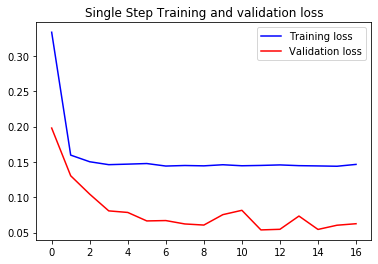

In [14]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

# Inference

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_15616 in device /job:localhost/replica:0/task:0/device:GPU:0


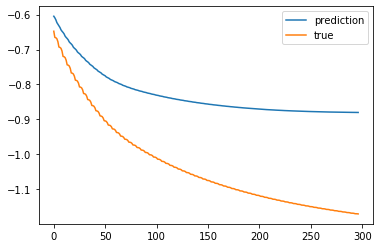

In [15]:
y_hat = single_step_model.predict(x_val_single)
# print(y_hat.shape)
# print(y_val_single.shape)
# print(y_train_single.shape)
plt.plot(y_hat[:,-1], label='prediction')
plt.plot(y_val_single, label='true')
plt.legend()
plt.show()

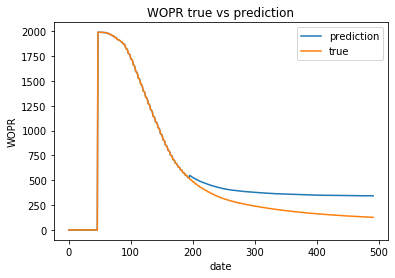

In [16]:
y_hat_inverse = y_hat[:,-1] * np.sqrt(scaler.var_[0]) + scaler.mean_[0]
y_val_inverse = y_val_single * np.sqrt(scaler.var_[0]) + scaler.mean_[0]
y_train_inverse = y_train_single * np.sqrt(scaler.var_[0]) + scaler.mean_[0]

y_train_inverse = y_train_inverse.reshape((-1, 1))
y_predicted = np.concatenate((y_train_inverse, y_hat_inverse), axis = None)
y_true = np.concatenate((y_train_inverse, y_val_inverse.reshape((-1, 1))), axis = None)

plt.plot(y_predicted, linestyle='-', label='prediction')
plt.plot(y_true, linestyle='-', label='true')
plt.xlabel('date')
plt.ylabel('WOPR')
plt.title('WOPR true vs prediction')
plt.legend()
plt.show()

# Evaluate the model

In [17]:
y_hat_inverse = y_hat[:,-1] * np.sqrt(scaler.var_[0]) + scaler.mean_[0]
y_val_inverse = y_val_single * np.sqrt(scaler.var_[0]) + scaler.mean_[0]
# print(y_hat_inverse.shape)
# print(y_val_inverse.reshape((-1, 1)).shape)

In [18]:
# calculate RMSE
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse = sqrt(mean_squared_error(y_val_inverse, y_hat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 159.121
